# Simple Regression Model for all links
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [ ]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import least_squares

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

#### Get AGIS endpoints (RSEs) and site names

In [ ]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Reading fts data for one day - all links

In [ ]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-04-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-03-31', 'fts_2017-04-01', 'fts_2017-04-02', 'fts_2017-04-03', 'fts_2017-04-04', 'fts_2017-04-05', 'fts_2017-04-06', 'fts_2017-04-07', 'fts_2017-04-08']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
22000000
23000000
24000000
25000000
Reading took 2936.0784304142 seconds.


In [9]:
#get all the links

links = []
for row in data.itertuples():
    if row.LINK not in links:
        links.append(row.LINK)
print(len(links))

9572


In [11]:
data['N_TIME'] = data['ENDED'] - data['STARTED']
data['N_TIME'][data.N_TIME <= 0] = 1
data['N_RATE'] = data.SIZE/data['N_TIME']
0 in data.N_TIME.values

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


False

# Non Linear Fit
rate[bytes/s] = size[bytes] / ( size [bytes]/constant1[bytes/s] + constant2[s]) limited to constant3[bytes/s]

where: 

constant3 is the limit on the transfer rate imposed by the disc read/write,

constant2 is the overhead time (time to establish connection, authenticate etc.),

constant1 is the rate

In [5]:

def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model
    

In [6]:
def get_model(link, data, show=False):
    cut = data.where(data.LINK == link).dropna()
    cut = cut.where(cut.SIZE > 0).dropna()
    cut = cut.where(cut.N_RATE > 0).dropna()
    if len(cut) < 20:
        return [-np.inf]*6
    vars = [cut.N_RATE.mean(), 1., 100.0]
    try:
        out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    except ValueError:
        print('Problem on link:', link, '. trying another start')
        try:
            first = cut[cut.SIZE < np.median(cut.SIZE)]
            p1 = np.polyfit(first.SIZE, first.N_RATE,1)
            p1 = np.poly1d(p1)
            secnd = cut[cut.SIZE > np.median(cut.SIZE)]
            p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
            p2 = np.poly1d(p2)
            oini=max(0.01,1/p1.coeffs[0])
            dini=max(0.01,1/p2.coeffs[0])
            vars = [cut.N_RATE.mean(), oini, dini]
            out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
        except ValueError:
            print('Couldn\'t solve problem for', link)
            return [-np.inf] * 6
    rate = out.x[0]
    overhead = out.x[1]
    diskrw = out.x[2]
    #print(link,out)
    cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    datalen = len(cut)
    if show:
        cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        plt.title('NETWORK rates for %s'%link)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Link Rate in MiB/s')
        plt.ylabel('Transfer rate in MiB/s')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show()
    return r2score, rmse, datalen, rate,overhead,diskrw
    

In [ ]:
#links_stats = []
for link in links[8066:]:
    try:
        rscore,rmse,datalen,rate,overhead,diskrw = get_model(link, data, show=False)
    except TypeError:
        print('Warning, link with very few data:', link)
        continue
    links_stats.append([link,rscore,rmse,datalen,rate,overhead,diskrw])

In [22]:
len(links_stats)

9571

In [40]:
rscores = np.array(links_stats)[:,1].astype('float')
rmses = np.array(links_stats)[:,2].astype('float')
dlens = np.array(links_stats)[:,3].astype('float')
rscores[rscores < -2] = -2
rmses[rmses == -np.inf] = (10**7.5)
rmses.min()
#rscores[rscores > 500] = 500

234.10335589300001

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


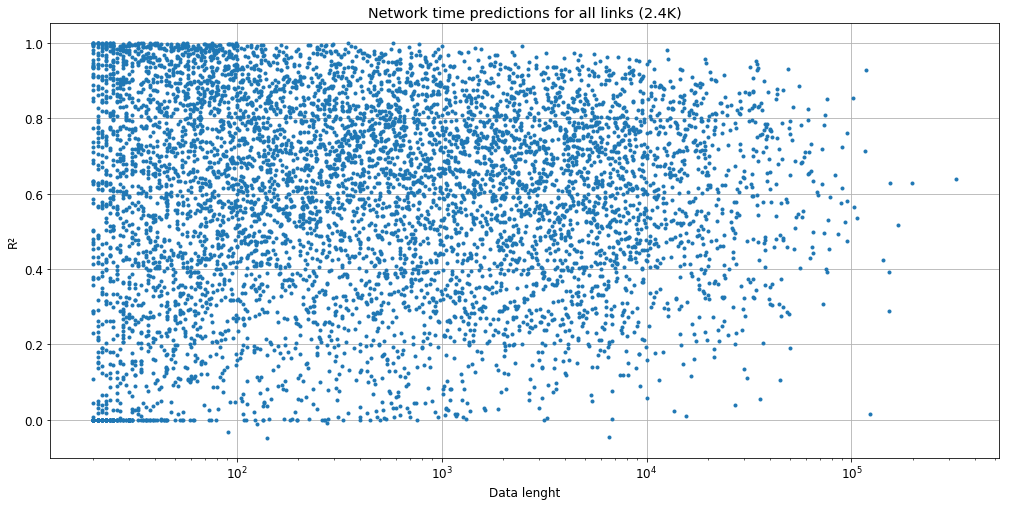

In [26]:
plt.plot(dlens,rscores,'.')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Data lenght')
plt.ylabel('R²')
plt.title('Network time predictions for all links (2.4K)')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


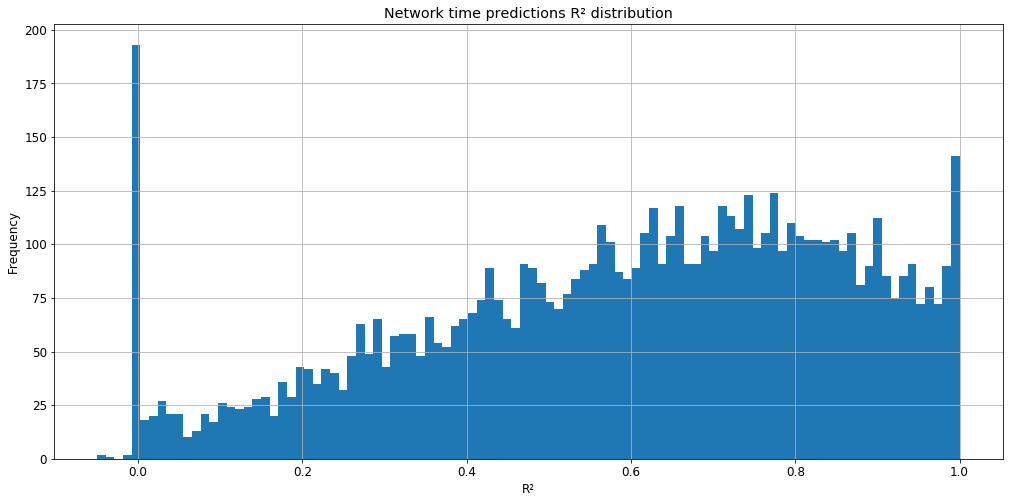

In [45]:
plt.hist(rscores[rscores != -2],bins=100)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('R²')
plt.title('Network time predictions R² distribution')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


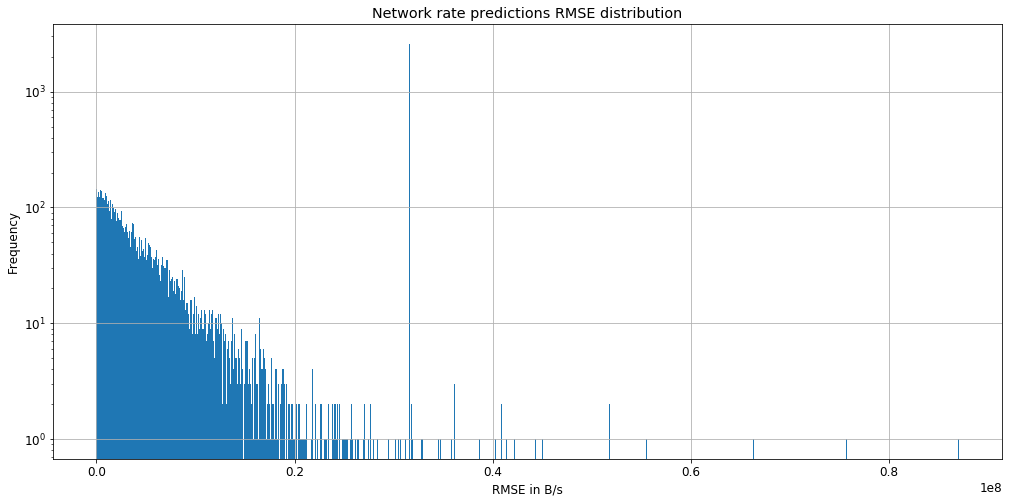

In [44]:
plt.hist(rmses,bins=1000)
#plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('RMSE in B/s')
plt.title('Network rate predictions RMSE distribution')
#plt.xlim((12000,20000000))
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


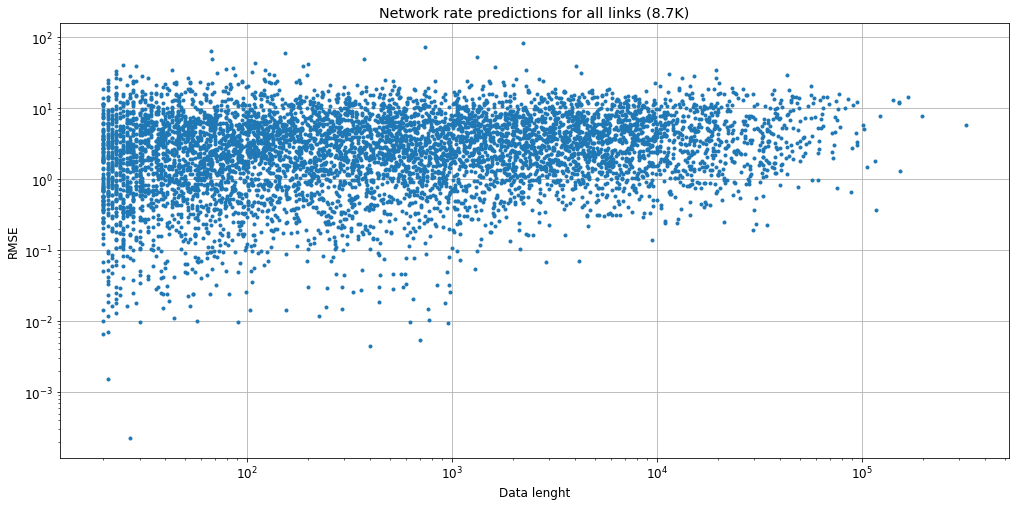

In [51]:
plt.plot(dlens,rmses/(1024*1024),'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data lenght')
plt.ylabel('RMSE')
plt.title('Network rate predictions for all links (8.7K)')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()

In [46]:
pickle.dump(links_stats, open('net_models-20170401-07-v2.pickle','wb'))
model = pd.DataFrame(links_stats, columns=['LINK','R2','RMSE','DATALEN','RATE','OVERHEAD','DISKRW'])

In [52]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-04-08'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-04-07', 'fts_2017-04-08', 'fts_2017-04-09', 'fts_2017-04-10', 'fts_2017-04-11', 'fts_2017-04-12', 'fts_2017-04-13', 'fts_2017-04-14', 'fts_2017-04-15']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
Reading took 3192.585899591446 seconds.


In [ ]:
links2 = [
for row in data.itertuples():
    if row.LINK in links and row.LINK not in links2:
        links2.append(row.LINK)
print(len(links))

In [ ]:
print(len(links2))

In [ ]:
print(test_model('CERN-PROD__BNL-ATLAS', data, True))
for l in links_stats:
    if 'CERN-PROD__BNL-ATLAS' in l:
        print(l)

In [ ]:
def test_model(link, data, show=False):
    cut = data.where(data.LINK == link).dropna()
    #cut = cut.where(cut.SIZE > 0).dropna()
    #cut = cut.where(cut.N_RATE > 0).dropna()
    if link not in model.LINK.values:
        #print('WARNING: no model found for', link,maxindex)
        cut['N_PRED'] = [-np.inf]*len(cut)
    else:
        rate = model[model.LINK == link].RATE.values[0]
        overhead = model[model.LINK == link].OVERHEAD.values[0]
        diskrw = model[model.LINK == link].DISKRW.values[0]
        cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
        cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    vars = [cut.N_RATE.mean(), .1, 100.0]
    out = leastsq(objective, vars, args=(cut.SIZE, cut.N_RATE))
    rate = out[0][0]
    overhead = out[0][1]
    diskrw = out[0][2] 
    #print(link,out)
    cut['N_PRED2'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    cut['N_PRED2'][cut['N_PRED2']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    try:
        r2score2 = r2(cut.N_RATE,cut.N_PRED2)
        rmse2 = np.sqrt(mse(cut.N_RATE,cut.N_PRED2))
    except ValueError:
        r2score2 = -np.Inf
        rmse2 = np.Inf
    datalen = len(cut)
    if show:
        cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        #plt.plot(cut.SIZE/(1024*1024), cut.N_PRED2/(1024*1024),'.', label='pred new')
        plt.title('NETWORK rates for %s'%link)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Link Rate in MiB/s')
        plt.ylabel('Transfer Size in MiB/s')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show()
    return r2score, rmse, datalen, rate, overhead, diskrw, r2score2, rmse2

In [ ]:
0

In [ ]:
links_stats = []
for link in links2:
    try:
        rscore,rmse,datalen,rate,overhead,diskrw,r2scores2,rmse2 = test_model(link, data, show=False)
    except TypeError:
        print('Warning, link with very few data:', link)
        continue
    links_stats.append([link,rscore,rmse,datalen,rate,overhead,diskrw,r2scores2,rmse2])

In [ ]:
link_stats = pd.DataFrame(links_stats, columns=['LINK','R2OLD','RMSEOLD','DATALEN', 'RATE','OVERH','DISKRW','R2','RMSE' ])

In [ ]:
link_stats

In [ ]:
0

In [ ]:
plt.plot(dlens,rscores,'.')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Data lenght')
plt.ylabel('R²')
plt.title('Network time predictions for all links (2.4K)')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
plt.show()